# 1. Imports

In [ ]:
!pip install transformers tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 32.3 MB/s 
     |████████████████████████████████| 6.6 MB 57.2 MB/s 
     |████████████████████████████████| 596 kB 57.9 MB/s 
     |████████████████████████████████| 101 kB 10.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from tqdm import tqdm
import torch.nn as nn
from tokenizers import ByteLevelBPETokenizer
from tokenizers.pre_tokenizers import Whitespace
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score

In [ ]:
# from google.colab import drive
# drive.mount('./drive')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 2. Data & Model Init

In [ ]:
TRAIN_FILE = '/content/h2i_01_asset_type_train_v1.csv'
VALID_FILE = '/content/h2i_01_asset_type_valid_v1.csv'
TEST_FILE = '/content/h2i_01_asset_type_test_v1.csv'

In [ ]:
train_df = pd.read_csv(TRAIN_FILE, encoding='utf-8').drop('Unnamed: 0', axis=1)
valid_df = pd.read_csv(VALID_FILE, encoding='utf-8').drop('Unnamed: 0', axis=1)
test_df = pd.read_csv(TEST_FILE, encoding='utf-8').drop('Unnamed: 0', axis=1)
train_df.head(5)

,text,label
0,Как инвестировать в недвижимость подскажи,0
1,можно мне вложиться в инвестиции,1
2,Инвестиции в золото это будет лучше инвестиции,0
3,Скажи мне вот меня интересует вопрос инвестици...,0
4,Во что инвестирует чаще всего?,1


In [ ]:
TEACHER_PATH = 'cointegrated/LaBSE-en-ru'

In [ ]:
bert_model = AutoModelForSequenceClassification.from_pretrained(TEACHER_PATH, num_labels=2)
tokenizer_bert = AutoTokenizer.from_pretrained(TEACHER_PATH)

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

# 3. Pretrained model on downstream task

## 3.1 Custom Dataset

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support


class BertClassifier:

    def __init__(self, path, n_classes=2):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=4, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=2e-5,
            weight_decay=0.005,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=1):
        print('*' * 10)
        print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x) for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x) for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
        print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [ ]:
# 0.97, 0.96 BCE

In [ ]:
import random
torch.manual_seed(42)
random.seed(42)

In [ ]:
classifier = BertClassifier(
    path="cointegrated/LaBSE-en-ru",
    n_classes=2
)

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

In [ ]:
EPOCHS = 1

In [ ]:
classifier.train(
        X_train=list(train_df['text']),
        y_train=list(train_df['label']),
        X_valid=list(valid_df['text']),
        y_valid=list(valid_df['label']),
        X_test=list(test_df['text']),
        y_test=list(test_df['label']),
        epochs=EPOCHS
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


**********
Model: cointegrated/LaBSE-en-ru
Epoch 1/1


100%|██████████| 651/651 [04:16<00:00,  2.54it/s]


Train loss 0.09875691210020296 accuracy 0.9788624135280554
Valid:
precision: 0.9689300680984809, recall: 0.9682402170714963, f1score: 0.9685135964015539
Test:
precision: 0.9770949903471745, recall: 0.9770949903471745, f1score: 0.9770949903471745
**********


In [ ]:
#0.977, 0.971 2 bc rubert-tiny
#0.98, 0.982 1 epoch 2 bc sbert-nlu-large

# 4. Distilation preparing

## 4.1 Define classes for distill

In [ ]:
class H2I01LSTM(nn.Module):
  
    def __init__(self, hidden_dim=256, vocab_size=3000, embedding_dim=300, linear_dim=64, dropout=0.3, n_classes=2):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(dropout)        
        self.fc_layer = nn.Linear(hidden_dim * 2, linear_dim)
        self.batchnorm = nn.BatchNorm1d(linear_dim)
        self.relu = nn.ReLU()
        self.out_layer = nn.Linear(linear_dim, n_classes)


    def forward(self, inputs):
        batch_size = inputs.size(0)
        embeddings = self.embedding_layer(inputs)
        lstm_out, (ht, ct) = self.lstm_layer(embeddings)
        out = ht.transpose(0, 1)
        out = out.reshape(batch_size, -1)
        out = self.fc_layer(out)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout_layer(out)
        out = self.out_layer(out)
        out = torch.squeeze(out, 1)
        out = torch.sigmoid(out)
        return out

## 4.2 Tokenizer & Vocab

In [ ]:
tokenizer = ByteLevelBPETokenizer()
tokenizer.pre_tokenizer = Whitespace()

tokenizer.enable_padding(pad_id=0, pad_token='<pad>')

In [ ]:
texts = [text.lower() for text in list(train_df['text'])]

In [ ]:
with open('texts.txt', 'w') as f:
    for text in texts:
        f.write("%s\n" % text)

In [ ]:
tokenizer.train(
    files=['texts.txt'],
    vocab_size=3_000,
    min_frequency=2,
    special_tokens=['<pad>', '<unk>']
    )

tokenizer.save('tokenizer.json')


In [ ]:
tokens_list = [tokenizer.encode(text).ids for text in texts]
train_df['tokens'] = tokens_list 
len_list = [len(tokens) for tokens in list(train_df['tokens'])]

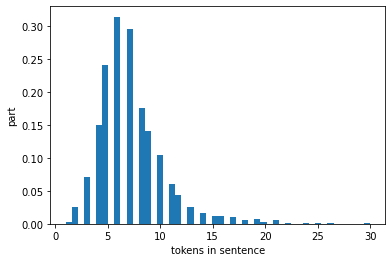

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(len_list, density=True, bins=50)
plt.ylabel('part')
plt.xlabel('tokens in sentence');

In [ ]:
max_len = 16

## 4.3 Dataloaders for distill model

In [ ]:
class DistillDataset(Dataset):

    def __init__(self, texts, labels, tokenizer_bert, tokenizer_lstm, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer_bert = tokenizer_bert
        self.tokenizer_lstm = tokenizer_lstm
        self.max_len = max_len


    def __len__(self):
        return len(self.texts)


    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        label = torch.tensor(label)
        # lstm
        tokens_lstm = self.tokenizer_lstm.encode(text.lower()).ids
        out_lstm = torch.zeros(self.max_len, dtype=torch.long)
        out_lstm[:len(tokens_lstm)] = torch.tensor(tokens_lstm, dtype=torch.long)[:self.max_len]
        # bert
        encoding = self.tokenizer_bert.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out_bert = {
              'input_ids': encoding['input_ids'].flatten().to(device),
              'attention_mask': encoding['attention_mask'].flatten().to(device)
        }
        return out_lstm, out_bert, label

In [ ]:
labels = list(train_df['label'])
train_dataset = DistillDataset(train_df['text'], labels, tokenizer_bert, tokenizer, max_len)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)

In [ ]:
# valid_texts = [text.lower() for text in list(valid_df['text'])]
valid_labels = list(valid_df['label'])
valid_dataset = DistillDataset(valid_df['text'], valid_labels, tokenizer_bert, tokenizer, max_len)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=10, shuffle=False)

In [ ]:
test_texts = [text.lower() for text in list(test_df['text'])]
test_ids = [tokenizer.encode(text).ids for text in test_texts]
test_labels = list(test_df['label'])
test_dataset = DistillDataset(test_df['text'], test_labels, tokenizer_bert, tokenizer, max_len)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

## 4.4 Trainer

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
class DistillTrainer():
  def __init__(self, a = 0.5):
    self.criterion_mse = torch.nn.MSELoss()
    self.criterion_ce = torch.nn.CrossEntropyLoss()
    self.a = a


  def train_epoch(self, model, optimizer, train_loader):
      train_loss = 0
      num_examples = 0
      model.train()
      for out_lstm, out_bert, labels in tqdm(train_loader, desc='Train'):
          out_lstm = out_lstm.to(device)#, out_bert.to(device), labels.to(device)
          model.zero_grad()
          output = model(out_lstm).squeeze(1)
          bert_logits = self.get_teacher_logits(out_bert)
          # print(output)
          # print(out_bert)
          # print(labels)
          loss = self.distill_loss(output.to(device), bert_logits.to(device),
                                   labels.to(device))
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          num_examples += len(labels)
      return train_loss / num_examples

  def evaluate_epoch(self, model, optimizer, valid_loader):
      eval_loss = 0.0
      acc = 0.0
      num_examples = 0
      predictions = None
      labels = None
      model.eval()
      for out_lstm, out_bert, label in tqdm(valid_loader, desc='Val'):
          out_lstm = out_lstm.to(device)#, out_bert.to(device), label.to(device)
          output = model(out_lstm)
          bert_logits = self.get_teacher_logits(out_bert)
          loss = self.distill_loss(output.to(device), bert_logits.to(device),
                          label.to(device))
          eval_loss += loss.item()

          probs = torch.softmax(output, dim=1)
          pred_label = torch.argmax(probs, dim=1)
          acc += torch.sum(pred_label.cpu() == label).cpu().numpy()
          num_examples += len(label)

          # predictions, labels = np.stack(predictions, labels, probs, label)

      return eval_loss / num_examples, acc / num_examples

  def get_teacher_logits(self, out_bert):
    with torch.no_grad():
      teacher_predict = classifier.model(input_ids=out_bert['input_ids'].to(device),
                                attention_mask=out_bert['attention_mask'].to(device)).logits
    return teacher_predict

  def distill_loss(self, output, bert_prob, real_label):
    return self.a * self.criterion_ce(output, real_label) + (1 - self.a) * self.criterion_mse(output, bert_prob)

  def train(self, model, train_loader, valid_loader, epochs, lr):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    acc_list = []
    for epoch in range(1, epochs+1):
      print(f'Training. Epoch - {epoch} of {epochs}')
      loss = self.train_epoch(model, optimizer, train_loader)
      print(f'Epoch loss - {loss}')
      print('Evaluating: ')
      loss, acc = self.evaluate_epoch(model, optimizer, valid_loader)
      acc_list.append(acc)
      print(f'Val loss: {loss}, accuracy: {acc}')
    return acc_list

In [ ]:
iter_list = [0, 0.25, 0.5, 0.75, 1]
score_list = []
for item_a in iter_list:
  model = H2I01LSTM()
  model.apply(init_weights)
  model.to(device)
  lr=1e-3
  epochs = 15
  trainer = DistillTrainer(item_a)
  score = trainer.train(model, train_loader, valid_loader, epochs, lr)
  score_list.append(score)

Training. Epoch - 1 of 15


Train: 100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Epoch loss - 0.15730847000251083
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 20.48it/s]


Val loss: 1.3842819268362863, accuracy: 0.9171428571428571
Training. Epoch - 2 of 15


Train: 100%|██████████| 27/27 [00:10<00:00,  2.47it/s]


Epoch loss - 0.14279129320066952
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.92it/s]


Val loss: 1.369633925301688, accuracy: 0.9228571428571428
Training. Epoch - 3 of 15


Train: 100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


Epoch loss - 0.14256493299397754
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.00it/s]


Val loss: 1.367005092075893, accuracy: 0.9257142857142857
Training. Epoch - 4 of 15


Train: 100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Epoch loss - 0.13991402003693634
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.72it/s]


Val loss: 1.3553739602225168, accuracy: 0.9371428571428572
Training. Epoch - 5 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


Epoch loss - 0.1385100351490487
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.47it/s]


Val loss: 1.360606109074184, accuracy: 0.9257142857142857
Training. Epoch - 6 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.46it/s]


Epoch loss - 0.13822547423665474
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.54it/s]


Val loss: 1.3613241141183037, accuracy: 0.94
Training. Epoch - 7 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.46it/s]


Epoch loss - 0.13776488820925573
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.88it/s]


Val loss: 1.3639371953691755, accuracy: 0.9314285714285714
Training. Epoch - 8 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Epoch loss - 0.13741685242766513
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.32it/s]


Val loss: 1.3510049274989537, accuracy: 0.9457142857142857
Training. Epoch - 9 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Epoch loss - 0.13706829509397914
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.06it/s]


Val loss: 1.350066795349121, accuracy: 0.9457142857142857
Training. Epoch - 10 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.13764183141926817
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.90it/s]


Val loss: 1.3483746446881975, accuracy: 0.9485714285714286
Training. Epoch - 11 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.46it/s]


Epoch loss - 0.1368026949642806
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.66it/s]


Val loss: 1.343503976549421, accuracy: 0.9542857142857143
Training. Epoch - 12 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.1365161361738318
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.54it/s]


Val loss: 1.344795434134347, accuracy: 0.9542857142857143
Training. Epoch - 13 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.13654656413882443
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.22it/s]


Val loss: 1.3403160667419434, accuracy: 0.9542857142857143
Training. Epoch - 14 of 15


Train: 100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Epoch loss - 0.13689642205410604
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.38it/s]


Val loss: 1.3517191777910504, accuracy: 0.94
Training. Epoch - 15 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Epoch loss - 0.1366263781026361
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.77it/s]


Val loss: 1.3462709672110422, accuracy: 0.9457142857142857
Training. Epoch - 1 of 15


Train: 100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


Epoch loss - 0.11819350215492572
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 26.99it/s]


Val loss: 1.0528976903642926, accuracy: 0.8942857142857142
Training. Epoch - 2 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.39it/s]


Epoch loss - 0.10809585060365928
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 26.81it/s]


Val loss: 1.031034208025251, accuracy: 0.9342857142857143
Training. Epoch - 3 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.10571034975367083
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.37it/s]


Val loss: 1.0303216879708426, accuracy: 0.9285714285714286
Training. Epoch - 4 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Epoch loss - 0.10551963889717964
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.01it/s]


Val loss: 1.0264880480085101, accuracy: 0.9285714285714286
Training. Epoch - 5 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Epoch loss - 0.10594821892547021
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.93it/s]


Val loss: 1.0242171478271485, accuracy: 0.9371428571428572
Training. Epoch - 6 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.10440662565092047
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.79it/s]


Val loss: 1.0268859018598284, accuracy: 0.9371428571428572
Training. Epoch - 7 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Epoch loss - 0.10389083628467558
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.27it/s]


Val loss: 1.023767043522426, accuracy: 0.9342857142857143
Training. Epoch - 8 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Epoch loss - 0.10349903410897632
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.53it/s]


Val loss: 1.0229881259373257, accuracy: 0.94
Training. Epoch - 9 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.10331673350909597
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.09it/s]


Val loss: 1.0215531022208078, accuracy: 0.9342857142857143
Training. Epoch - 10 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.10328713533605272
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.15it/s]


Val loss: 1.0220486967904228, accuracy: 0.9342857142857143
Training. Epoch - 11 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Epoch loss - 0.10324129886026111
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 20.15it/s]


Val loss: 1.0202635029384068, accuracy: 0.9371428571428572
Training. Epoch - 12 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Epoch loss - 0.10327155437953284
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.93it/s]


Val loss: 1.0203430094037738, accuracy: 0.94
Training. Epoch - 13 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Epoch loss - 0.10315044470515093
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.73it/s]


Val loss: 1.0192643628801619, accuracy: 0.94
Training. Epoch - 14 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Epoch loss - 0.10306229635351534
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.91it/s]


Val loss: 1.0174068205697195, accuracy: 0.9457142857142857
Training. Epoch - 15 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.10299830982815203
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.90it/s]


Val loss: 1.0233301380702426, accuracy: 0.9314285714285714
Training. Epoch - 1 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Epoch loss - 0.08159351916976565
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.60it/s]


Val loss: 0.7227471147264753, accuracy: 0.8971428571428571
Training. Epoch - 2 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.07407669815808236
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.31it/s]


Val loss: 0.714027840750558, accuracy: 0.9085714285714286
Training. Epoch - 3 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.07219070457294297
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.78it/s]


Val loss: 0.695009799684797, accuracy: 0.9428571428571428
Training. Epoch - 4 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.07171408237630271
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.41it/s]


Val loss: 0.6995813846588135, accuracy: 0.9257142857142857
Training. Epoch - 5 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Epoch loss - 0.07068319086108549
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.54it/s]


Val loss: 0.6932168361118861, accuracy: 0.9428571428571428
Training. Epoch - 6 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.0703219955101277
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.44it/s]


Val loss: 0.6907625239236014, accuracy: 0.9485714285714286
Training. Epoch - 7 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.46it/s]


Epoch loss - 0.0701518513256545
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.38it/s]


Val loss: 0.6926211670466832, accuracy: 0.9457142857142857
Training. Epoch - 8 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.07002254360735553
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.94it/s]


Val loss: 0.6933705724988665, accuracy: 0.94
Training. Epoch - 9 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.06989988558664402
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.84it/s]


Val loss: 0.6909154714856829, accuracy: 0.9457142857142857
Training. Epoch - 10 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.06986587859409575
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.07it/s]


Val loss: 0.6911373955862863, accuracy: 0.9428571428571428
Training. Epoch - 11 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Epoch loss - 0.06992948229362377
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.47it/s]


Val loss: 0.6966696657453264, accuracy: 0.9371428571428572
Training. Epoch - 12 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.06982346519335338
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.93it/s]


Val loss: 0.6884831510271345, accuracy: 0.9542857142857143
Training. Epoch - 13 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Epoch loss - 0.06976505740617991
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.20it/s]


Val loss: 0.6884256703513009, accuracy: 0.9485714285714286
Training. Epoch - 14 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.41it/s]


Epoch loss - 0.06973514494577067
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.22it/s]


Val loss: 0.6906349263872419, accuracy: 0.9457142857142857
Training. Epoch - 15 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.06971218162642177
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.30it/s]


Val loss: 0.6882375853402274, accuracy: 0.9485714285714286
Training. Epoch - 1 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Epoch loss - 0.04363696690617297
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.23it/s]


Val loss: 0.3756592975343977, accuracy: 0.9114285714285715
Training. Epoch - 2 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Epoch loss - 0.03977694747816316
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.75it/s]


Val loss: 0.37516673360552105, accuracy: 0.9171428571428571
Training. Epoch - 3 of 15


Train: 100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Epoch loss - 0.038233505131005326
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.03it/s]


Val loss: 0.37149487018585203, accuracy: 0.9314285714285714
Training. Epoch - 4 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.03771357211949365
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.07it/s]


Val loss: 0.369668596131461, accuracy: 0.9314285714285714
Training. Epoch - 5 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.037440111323744404
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.26it/s]


Val loss: 0.366592561176845, accuracy: 0.94
Training. Epoch - 6 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.03719948347855494
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.75it/s]


Val loss: 0.3685635314668928, accuracy: 0.9314285714285714
Training. Epoch - 7 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.0371739979801867
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.88it/s]


Val loss: 0.3700044400351388, accuracy: 0.9228571428571428
Training. Epoch - 8 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Epoch loss - 0.038270355187224755
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.50it/s]


Val loss: 0.3714235292162214, accuracy: 0.9142857142857143
Training. Epoch - 9 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.03829347620003046
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.61it/s]


Val loss: 0.37210292611803325, accuracy: 0.9114285714285715
Training. Epoch - 10 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.03731918664825228
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.83it/s]


Val loss: 0.36840332916804724, accuracy: 0.9228571428571428
Training. Epoch - 11 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.03694343860107234
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.51it/s]


Val loss: 0.3666986860547747, accuracy: 0.9342857142857143
Training. Epoch - 12 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.036803223645109844
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.33it/s]


Val loss: 0.36572339739118304, accuracy: 0.9428571428571428
Training. Epoch - 13 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.036719151683077274
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.55it/s]


Val loss: 0.36552660601479664, accuracy: 0.94
Training. Epoch - 14 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.0366663751374933
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.62it/s]


Val loss: 0.36469296182904926, accuracy: 0.94
Training. Epoch - 15 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Epoch loss - 0.03664706698937383
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.77it/s]


Val loss: 0.3648044286455427, accuracy: 0.9428571428571428
Training. Epoch - 1 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Epoch loss - 0.005594697241871106
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.86it/s]


Val loss: 0.04233501638684954, accuracy: 0.9
Training. Epoch - 2 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.004394451109012395
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.37it/s]


Val loss: 0.04101375503199441, accuracy: 0.9085714285714286
Training. Epoch - 3 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Epoch loss - 0.004022362047117733
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.75it/s]


Val loss: 0.0402524128981999, accuracy: 0.9057142857142857
Training. Epoch - 4 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.0037461286045605176
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.33it/s]


Val loss: 0.03881882071495056, accuracy: 0.9285714285714286
Training. Epoch - 5 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.00358046308377447
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.03it/s]


Val loss: 0.03804199397563934, accuracy: 0.9314285714285714
Training. Epoch - 6 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.0034824332807908876
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.51it/s]


Val loss: 0.03745278443608965, accuracy: 0.94
Training. Epoch - 7 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.003434696042198662
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.32it/s]


Val loss: 0.03680268517562321, accuracy: 0.9457142857142857
Training. Epoch - 8 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.0033935934625892433
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.22it/s]


Val loss: 0.03688540995121002, accuracy: 0.9485714285714286
Training. Epoch - 9 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Epoch loss - 0.003374608581474797
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.68it/s]


Val loss: 0.03708484309060233, accuracy: 0.94
Training. Epoch - 10 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Epoch loss - 0.003357938637557532
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.51it/s]


Val loss: 0.037079653569630215, accuracy: 0.9371428571428572
Training. Epoch - 11 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.0033430977682257323
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.52it/s]


Val loss: 0.03709511143820626, accuracy: 0.94
Training. Epoch - 12 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Epoch loss - 0.003335526432100394
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.65it/s]


Val loss: 0.03692780894892556, accuracy: 0.9428571428571428
Training. Epoch - 13 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.0033229803874069317
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 28.89it/s]


Val loss: 0.03627637386322022, accuracy: 0.9457142857142857
Training. Epoch - 14 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Epoch loss - 0.003314693818451532
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.75it/s]


Val loss: 0.03645960254328592, accuracy: 0.9457142857142857
Training. Epoch - 15 of 15


Train: 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Epoch loss - 0.003310943421815378
Evaluating: 


Val: 100%|██████████| 35/35 [00:01<00:00, 27.09it/s]

Val loss: 0.03644223383494786, accuracy: 0.9428571428571428


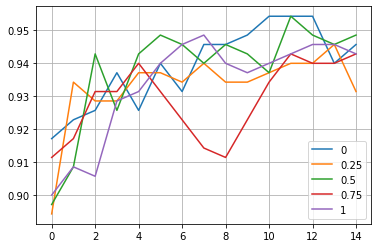

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

a_list = [0, 0.25, 0.5, 0.75, 1]

for i, score in enumerate(score_list):
    # _, score_test = list(zip(*score))
    plt.plot(score, label=f'{a_list[i]}')
plt.grid(True)
plt.legend()
plt.show()

# The result with distillation is better than without